In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools as it
tfk = tf.keras
tfkl = tf.keras.layers
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing

In [5]:
import yfinance

[Paper](https://jfds.pm-research.com/content/iijjfds/2/4/8.full.pdf)

# EDA

In [6]:
START_DATE = '2006-02-06' #DBC starts at 6 feb 2006
END_DATE ='2020-04-30'

In [7]:
# Bond,Commodities,Stocks,Volatility
etfs=['AGG','DBC','VTI','^VIX']

data = pd.DataFrame()

for etf in etfs:
    data[etf] = yfinance.Ticker(etf).history(start=START_DATE,end=END_DATE)['Close']
data

,AGG,DBC,VTI,^VIX
Date,,,,
2006-02-06,60.830357,22.048342,46.426849,13.040000
2006-02-07,60.787918,21.410580,45.974823,13.590000
2006-02-08,60.757584,21.319471,46.305569,12.830000
2006-02-09,60.794006,21.519909,46.217361,13.120000
2006-02-10,60.666523,21.128141,46.312920,12.870000
...,...,...,...,...
2020-04-23,112.726517,10.840000,135.572388,41.380001
2020-04-24,112.668922,10.700000,137.593079,35.930000
2020-04-27,112.150490,10.500000,140.031525,33.290001


<AxesSubplot:xlabel='Date'>

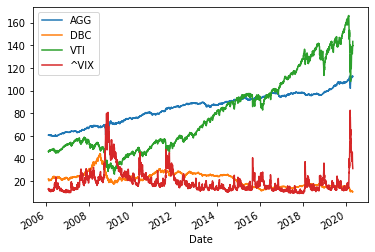

In [8]:
data.plot()

In [9]:
def correlation_analysis(df, lookback_window):
    etfs_pairs = list(it.combinations(df.columns, 2))
    correlation = pd.DataFrame()
    for pair in etfs_pairs:
        correlation[str(pair[0])+' <--> '+str(pair[1])] = df[list(pair)].rolling(lookback_window).corr().iloc[0::2,-1].droplevel(1, axis=0)
    return correlation
lookback = 50
rolling_corrs = correlation_analysis(data.pct_change().fillna(0), lookback)[49:] #first 49 values are NaN due to lookback = 50

<AxesSubplot:xlabel='Date'>

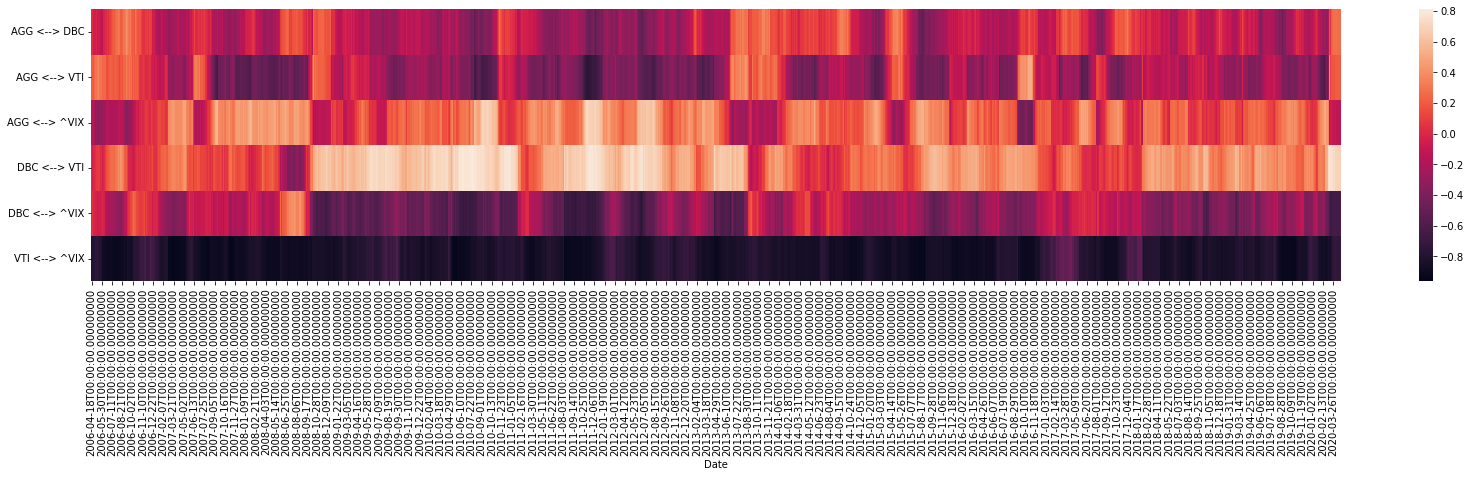

In [10]:
fig, ax = plt.subplots(1,1, figsize=(28,5))
sns.heatmap(rolling_corrs.transpose())

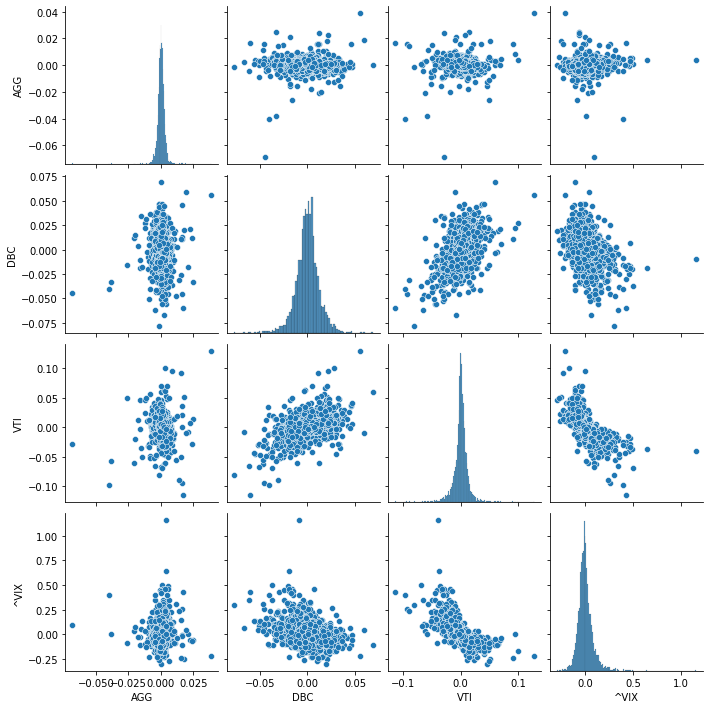

In [11]:
returns = data.pct_change()[1:].fillna(0)
sns.pairplot(data.pct_change());

Returns are normally distributed?

In [12]:
from scipy.stats import kurtosis,skew,jarque_bera

kurtosis(returns),skew(returns)

(array([80.38633881,  2.95622168, 13.26778354, 16.64565228]),
 array([-2.95846295, -0.30755146, -0.18655145,  2.08440118]))

Returns are not normally distributed. Normality of returns are main assumptions of SharpeRatio

In [10]:
for i in returns.columns:
    _,p_value = jarque_bera(returns[i])
    print("Normality test of " + i + " return: " + str(p_value>0.05))

Normality test of AGG return: False
Normality test of DBC return: False
Normality test of VTI return: False
Normality test of ^VIX return: False


In [11]:
from sklearn.preprocessing import StandardScaler

def standardize_train(data):
    # scale prices and returns in train set
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=scaler.get_feature_names_out())
    return scaler , data #return also scaler because we need it to standardize valid and test set

def standardize(data,scaler):
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=scaler.get_feature_names_out())
    return data #return also scaler because we need it to standardize valid and test set


# TRAIN-TEST SPLIT

In [12]:
train = data.loc[:'2016-02-6'] # ~80%
val = data.loc['2016-02-06':'2018-01-01'] # ~10%
test = data.loc['2018-01-01':] # ~10%
train.shape, val.shape, test.shape

((2518, 4), (479, 4), (585, 4))

Compute returns

In [13]:
def add_pct_change(data):
    percentage_returns = data.pct_change()
    percentage_returns.fillna(0,inplace=True)
    percentage_returns.columns = ['%returnsAGG','%returnsDBC','%returnsVTI','%returnsVIX']
    percentage_returns.index = data.index
    return pd.concat([data,percentage_returns],axis=1)

train_with_returns = add_pct_change(train)
val_with_returns = add_pct_change(val)
test_with_returns = add_pct_change(test)

In [14]:
#scaler, train_with_returns = standardize_train(train_with_returns)
#val_with_returns = standardize(val_with_returns,scaler)
#test_with_returns = standardize(test_with_returns,scaler)

Build sequences of 50 days

In [15]:
window = 50 # from paper

def build_sequences(data,predict_data,window):
    X,y = [],[]
    for i in range(data.shape[0] - window):
        X.append(data[i:(i+window)])
        y.append(predict_data.iloc[i+window])
    return np.array(X),np.array(y)

X_train,y_train = build_sequences(train_with_returns,train,window)
X_val,y_val = build_sequences(val_with_returns,val,window)
X_test,y_test = build_sequences(test_with_returns,test,window)

In [16]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((2468, 50, 8), (2468, 4), (429, 50, 8), (429, 4), (535, 50, 8), (535, 4))

# FIRST APPROACH

Since I want to maximize Sharpe Ratio, while gradient descent minimizes is built to minimize input function, I negate Sharpe Ratio.

Tensorflow loss function takes as input:
- y_true: this is our y_train values.
- y_pred: this is prediction.

In this case y_pred represents weights of the portfolio and y_true represent values of portfolio.

#### Custom Training

In [127]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(batch_size)

In [128]:
input_shape,output_shape = list(X_train.shape[1:]),y_train.shape[1:][0]

In [129]:
input_layer = tfkl.Input(shape=input_shape, name='Input',dtype='float32')
lstm = tfkl.LSTM(units=64)(input_layer)
output_layer = tfkl.Dense(output_shape, activation='softmax')(lstm)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

In [130]:
# Instantiate an optimizer.
optimizer = tfk.optimizers.Adam(learning_rate=1e-4)

In [131]:
class NegativeSharpeRatioLoss(tfk.losses.Loss):
    def __init__(self, name="Sharpe Ratio Loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        portfolio_values = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=1)

        portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

        sharpe = tfk.backend.mean(portfolio_returns) / tfk.backend.std(portfolio_returns)
        return -sharpe

def compute_sharpe_ratio(weights,data):
    if type(data) != pd.DataFrame:
        data = pd.DataFrame(data)
    portfolio_values = weights*data
    portfolio_values = [sum(portfolio_values.iloc[i]) for i in range(portfolio_values.shape[0])]
    portfolio_returns = (np.subtract(portfolio_values[1:], portfolio_values[:-1]))/portfolio_values[:-1]
    return np.mean(portfolio_returns)/np.std(portfolio_returns)

In [132]:
epochs = 200
training_loss = []
val_metric=[]
def training(model,train_dataset,val_dataset,custom_loss):
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch))

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                logits = model(x_batch_train,training=True)  # Logits for this minibatch

                # Compute the loss value for this minibatch.
                loss_value = custom_loss(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 20 batches.
        #if step % 20 == 0:
            #print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
            #print("Seen so far: %s samples" % ((step + 1) * batch_size))
        print("Training loss at epoch %d: %.4f" % (epoch, float(loss_value)))
        training_loss.append(loss_value)

        weights,values=None,None
        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            if weights is None:
                weights=val_logits
                values=y_batch_val
            else:
                weights = np.concatenate([np.array(weights,dtype=float),np.array(val_logits,dtype=float)])
                values = np.concatenate([np.array(values,dtype=float),np.array(y_batch_val,dtype=float)])
        sr = compute_sharpe_ratio(weights,values)

        print("Validation metric at epoch %d: %.4f" % (epoch, float(sr)))
        val_metric.append(sr)

training(model,train_dataset,val_dataset,NegativeSharpeRatioLoss())


Start of epoch 0
Training loss at epoch 0: -0.0199
Validation metric at epoch 0: 0.0461

Start of epoch 1
Training loss at epoch 1: -0.0218
Validation metric at epoch 1: 0.0499

Start of epoch 2
Training loss at epoch 2: -0.0220
Validation metric at epoch 2: 0.0539

Start of epoch 3
Training loss at epoch 3: -0.0199
Validation metric at epoch 3: 0.0585

Start of epoch 4
Training loss at epoch 4: -0.0155
Validation metric at epoch 4: 0.0638

Start of epoch 5
Training loss at epoch 5: -0.0084
Validation metric at epoch 5: 0.0700

Start of epoch 6
Training loss at epoch 6: 0.0011
Validation metric at epoch 6: 0.0773

Start of epoch 7
Training loss at epoch 7: 0.0135
Validation metric at epoch 7: 0.0858

Start of epoch 8
Training loss at epoch 8: 0.0287
Validation metric at epoch 8: 0.0954

Start of epoch 9
Training loss at epoch 9: 0.0443
Validation metric at epoch 9: 0.1052

Start of epoch 10
Training loss at epoch 10: 0.0556
Validation metric at epoch 10: 0.1142

Start of epoch 11
Trai

Text(0, 0.5, 'Sharpe ratio')

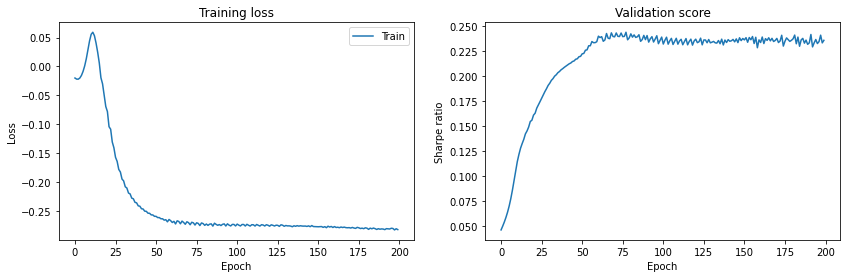

In [136]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.plot(training_loss)
ax1.legend(['Train'])
ax1.set_title('Training loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(val_metric)
ax2.set_title('Validation score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sharpe ratio')

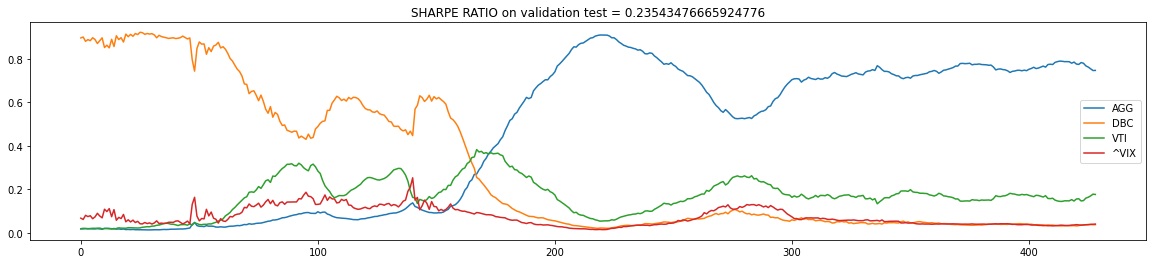

In [142]:
predictions = model.predict(X_val)
df = np.array(predictions).transpose()
plt.figure(figsize=[20,4])
for i in range(df.shape[0]):
    plt.plot(df[i],label=etfs[i])
plt.title('SHARPE RATIO on validation test = ' + str(compute_sharpe_ratio(predictions,val[50:])))
plt.legend()

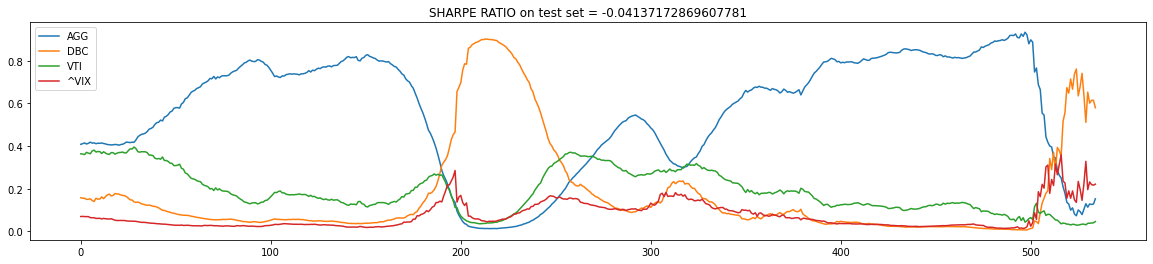

In [143]:
predictions = model.predict(X_test)
df = np.array(predictions).transpose()
plt.figure(figsize=[20,4])
for i in range(df.shape[0]):
    plt.plot(df[i],label=etfs[i])
plt.title('SHARPE RATIO on test set = ' + str(compute_sharpe_ratio(predictions,test[50:])))
plt.legend()

# OTHER APPROACH: LSTM for prediction + optimize

In [17]:
window = 50

def build_sequences(data,returns,window):
    X = []
    y = []
    for i in range(returns.shape[0] - window):
        x_i = returns[i:(i+window)]
        X.append(x_i)
        y_i = returns.iloc[i+window]
        y.append(y_i)
    return np.array(X),np.array(y)

#X_train,y_train = build_sequences(None,train,window)
#X_val,y_val = build_sequences(None,val,window)

In [18]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
batch_size = 64
epochs = 200

In [19]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(units=64,return_sequences=True)(input_layer)
    dense = tfkl.Dense(32)(lstm)
    flattening = tfkl.Flatten()(dense)
    output_layer = tfkl.Dense(output_shape, activation='relu')(flattening)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=[tfk.losses.MeanSquaredError(),], optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [20]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 50, 8)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 64)            18688     
_________________________________________________________________
dense (Dense)                (None, 50, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 6404      
Total params: 27,172
Trainable params: 27,172
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/downloa

In [21]:
history = model.fit(X_train,y_train,epochs=500,validation_split=.2,
                    callbacks = [
                        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
                        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-7)
                    ])

Epoch 1/500
62/62 [==============================] - 2s 15ms/step - loss: 812.4477 - mae: 21.3765 - val_loss: 469.9204 - val_mae: 18.3421
Epoch 2/500
62/62 [==============================] - 1s 11ms/step - loss: 150.7343 - mae: 8.7264 - val_loss: 443.4243 - val_mae: 15.7575
Epoch 3/500
62/62 [==============================] - 1s 11ms/step - loss: 47.8073 - mae: 4.8148 - val_loss: 309.2627 - val_mae: 13.2756
Epoch 4/500
62/62 [==============================] - 1s 12ms/step - loss: 22.5375 - mae: 3.3624 - val_loss: 157.9153 - val_mae: 9.9633
Epoch 5/500
62/62 [==============================] - 1s 12ms/step - loss: 13.2079 - mae: 2.4037 - val_loss: 123.3472 - val_mae: 9.0346
Epoch 6/500
62/62 [==============================] - 1s 13ms/step - loss: 9.1870 - mae: 1.9762 - val_loss: 100.7160 - val_mae: 8.1144
Epoch 7/500
62/62 [==============================] - 1s 12ms/step - loss: 6.7720 - mae: 1.7301 - val_loss: 83.7131 - val_mae: 7.1917
Epoch 8/500
62/62 [==============================] -

In [124]:
model.save_weights('model_w_ret')

In [21]:
model.load_weights('model_w_ret')

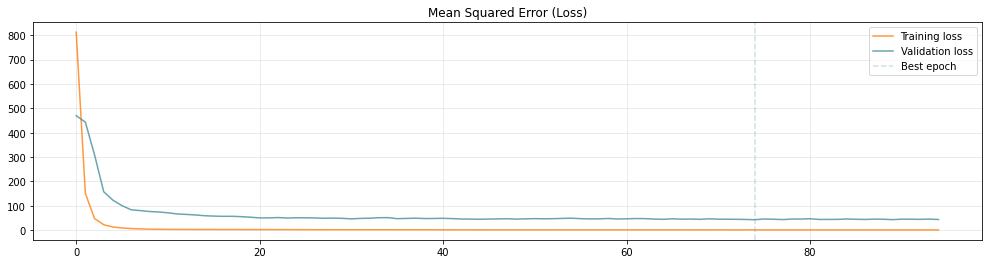

In [127]:
best_epoch = np.argmin(history.history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history.history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
# Predict the val set
predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.numpy().flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.numpy().flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(429, 4)


(<tf.Tensor: shape=(), dtype=float32, numpy=387.18506>,
 <tf.Tensor: shape=(), dtype=float32, numpy=14.141884>)

<Figure size 1224x288 with 0 Axes>

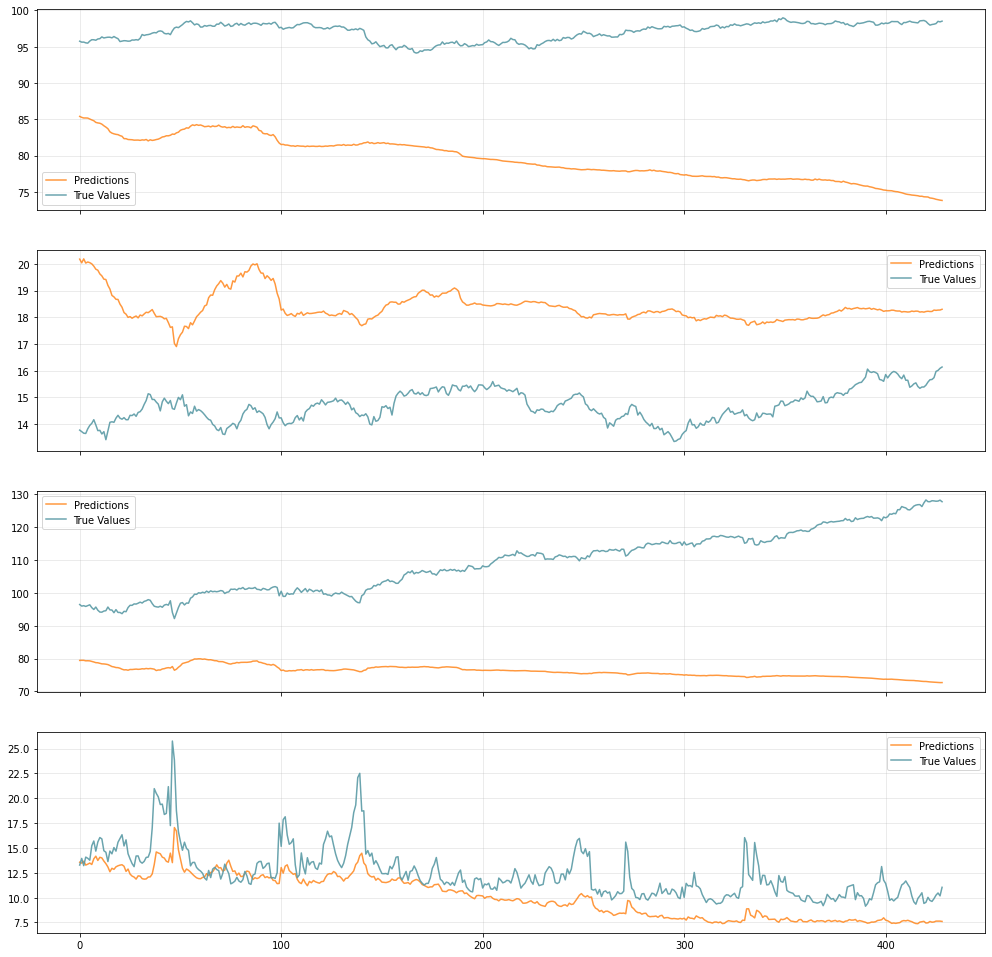

In [29]:
plt.figure(figsize=(17,4))
figs, axs = plt.subplots(4, 1, sharex=True, figsize=(17,17))
for i in range(4):
    axs[i].plot(predictions[:,i], label='Predictions', alpha=.8, color='#ff7f0e')
    axs[i].plot(y_val[:,i], label='True Values', alpha=.9, color='#5a9aa5')
    axs[i].legend()
    axs[i].grid(alpha=.3)
plt.show()

## OPTIMIZE SHARPE RATIO

#### First approach

Classic Sharpe Ratio formula

In [30]:
import scipy.optimize as opt
def MaximizeSharpeRatio(data):
    # define negative sharpe ratio
    def  f(x, mean, cov):
        funcDen = np.sqrt(np.matmul(np.matmul(x, cov), x.T) )
        funcNumer = np.matmul(np.array(mean),x.T)
        func = -(funcNumer / funcDen)
        return func

    size = data.shape[1]
    mean = np.mean(data,axis=0)
    covar = np.cov(data,rowvar=False)
    #define bounds and other parameters
    xinit=np.repeat(1/size, size)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
    bnds = opt.Bounds(([0 for x in xinit]), [1 for x in xinit], keep_feasible=True)

    solver = opt.minimize(f, x0 = xinit, args = (mean, covar), method = 'SLSQP',
                             bounds = bnds,constraints=cons, tol = 10**-3,options={'disp':True})
    return solver

In [31]:
weights=[]
sharpe_values = []
for i in range(X_val.shape[0]):
    np.append(X_val[i][:,:4], model.predict((X_val[i])[np.newaxis,:]) ,axis=0)
    returns =(X_val[i][:,:4][1:] - X_val[i][:,:4][:-1]) / X_val[i][:,:4][:-1]
    solver = MaximizeSharpeRatio(returns)
    if solver.success:
        weights.append(solver.x)
        sharpe_values.append(solver.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5666795618746631
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5718235724196419
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5261071244964289
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5249160949421802
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5013364116611003
            Iterations: 12
            Functio

Mean Sharpe Ratio over validation set

In [32]:
np.mean(sharpe_values)*(-1)

0.3392828930351479

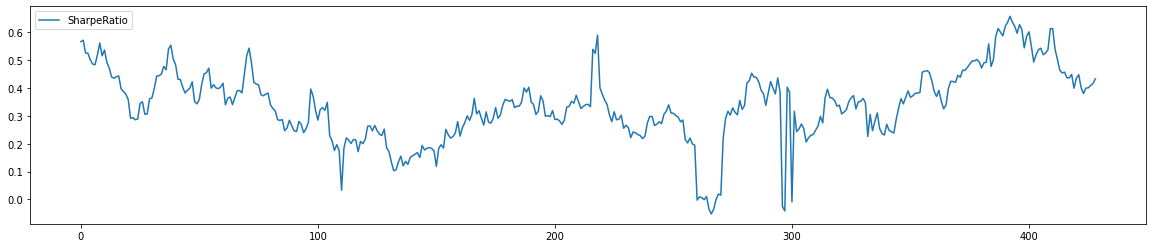

In [33]:
plt.figure(figsize=[20,4])
plt.plot(np.multiply(sharpe_values,(-1)),label='SharpeRatio')
plt.legend()

Plot weights over time, starting from '2016-02-06' to '2018-01-01'

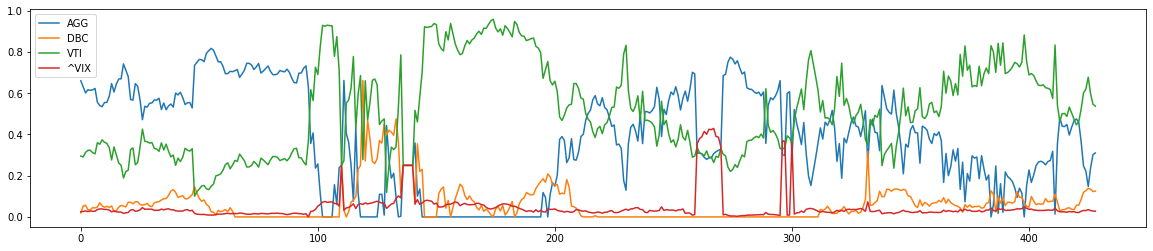

In [34]:
df = np.array(weights).transpose()
plt.figure(figsize=[20,4])
for i in range(df.shape[0]):
    plt.plot(df[i],label=etfs[i])
plt.legend()

### Second approach (not finished)

Try to modify Sharpe Ratio formula.

k = 1 / (returns.T * W)
y = kW

(W.T * covariance * W)^(.5)  =>  (y.T * covariance * y)/k
returns.T * y = 1

So this is new objective function:

MINIMIZE y.T * covariance * y

subject to:
- y > 0
- returns.T * y = 1

In [29]:
from cvxopt import solvers,matrix

In [111]:
def QP(return_data):
    mean = np.mean(return_data,axis=0)
    cov = np.cov(return_data,rowvar=False)
    number_stock=mean.shape[0]
    #SRnumer = np.matmul(np.array(mean),x.T)
    #k = 1 / SRnumer
    #y = np.multiply(k,x)

    #obj function
    Q= matrix(cov)
    #coefficient linear part
    p=matrix(np.zeros(number_stock))
    #inequality coefficient
    G=matrix(-np.eye(number_stock))
    #inequality value
    h=matrix(np.zeros(number_stock))
    #equality coefficient
    A=matrix(mean*np.eye(number_stock))
    #equality value
    b=matrix(np.repeat(1.0,number_stock))
    sol=solvers.qp(Q,p,G, h, A, b )
    fraction=np.array(sol['x'])[:,0]
    return sol,fraction

In [112]:
weights=[]
sharpe_values = []
for i in range(X_val.shape[0]):
    np.append(X_val[i][:,:4], model.predict((X_val[i])[np.newaxis,:]) ,axis=0)
    returns =(X_val[i][:,:4][1:] - X_val[i][:,:4][:-1]) / X_val[i][:,:4][:-1]
    values = QP(returns)
    print(values)

     pcost       dcost       gap    pres   dres
 0:  5.4182e+01 -1.9997e+06  3e+06  2e+02  7e+03
 1:  5.4182e+01  2.2435e+07  3e+06  2e+02  7e+03
 2:  5.4182e+01  2.0507e+11  3e+06  2e+02  7e+03
 3:  5.4182e+01  1.7014e+17  2e+09  2e+02  7e+03
 4:  5.4182e+01  1.4115e+25  2e+15  2e+02  7e+07
 5:  5.4182e+01  1.1711e+35  1e+23  2e+02  6e+03
 6:  5.4182e+01  9.7161e+46  1e+33  2e+02  6e+03
 7:  5.4182e+01  8.0644e+60  1e+45  2e+02  2e+43
 8:  5.4182e+01  2.5557e+76  3e+58  2e+02  5e+58
 9:  3.8098e+03  1.7948e+112  2e+94  1e+03  3e+94
10:  1.3546e+04  6.8618e+147  8e+129  3e+03 2e+130
11:  1.2915e+04  2.5183e+182  3e+164  3e+03    inf
12:  4.6231e+04  1.7431e+218  2e+200  5e+03  1e-14
13:  6.9576e+04  4.1235e+253  5e+235  6e+03  7e-15
14:  4.2362e+04  2.8159e+289  3e+291  5e+03  9e-13
15:  2.6570e+01  2.8610e+289  4e+289  1e+02    inf
16:  3.8078e+01  6.4310e+289  8e+287  4e+01    inf
17:  3.8236e+01  5.2986e+291  7e+287  4e+01  1e-13
18:  3.8238e+01  4.2618e+295  5e+289  4e+01    inf
19

ValueError: domain error

In [120]:
import math
import scipy.optimize as opt
class sr:
    def MinimizeRedefinedSharpeRatio(self,data):
        # define negative sharpe ratio
        def  f(x, mean, cov):
            SRnumer = np.matmul(np.array(mean),x.T)
            k = 1 / SRnumer
            y = np.multiply(k,x)
            SRden = np.sqrt(np.matmul(np.matmul(y.T, cov), y) )
            return SRden

        def constraint(x):
            SRnumer = np.multiply(np.array(self.mean),x.T)
            k = 1/SRnumer
            y = np.multiply(k,x)
            return np.matmul(np.array(self.mean.T),y) - 1

        def constraint2(x):
            SRnumer = np.multiply(np.array(self.mean),x.T)
            k = 1/SRnumer
            return k

        size = data.shape[1]
        self.mean = np.mean(data,axis=0)
        self.covar = np.cov(data,rowvar=False)
        #define bounds and other parameters
        xinit=np.repeat(1/size, size)
        cons = ({'type': 'eq', 'fun': constraint},{'type': 'ineq', 'fun': constraint2})

        bnds = opt.Bounds(([(0) for x in xinit]),[(1) for x in xinit],keep_feasible=True)

        #invoke minimize solver
        solver = opt.minimize(f, x0 = xinit, args = (self.mean, self.covar), method = 'SLSQP',
                              bounds = bnds,constraints=cons, tol = 10**-5,options={'disp':True})
        return solver

In [22]:
weights=[]
sharpe_values = []
for i in range(X_val.shape[0]):
    np.append(X_val[i][:,:4], model.predict((X_val[i])[np.newaxis,:]) ,axis=0)
    returns =(X_val[i][:,:4][1:] - X_val[i][:,:4][:-1]) / X_val[i][:,:4][:-1]
    solver = sr().MinimizeRedefinedSharpeRatio(returns)
    if solver.success:
        weights.append(solver.x)
        sharpe_values.append(solver.fun)

Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 59.95692976583856
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 72.1855913133524
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 102.43020864512563
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 43.48784008049737
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 100.91209542147143
            Iterations: 1
            Function evaluations: 5
          